In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter #to change scientific format

# Functions
def format_y_axis():    
    ax = plt.gca()
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)
    
def format_y_axis_subplot(ax):    
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)

In [3]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])
transactions_df = pd.read_csv('transactions.csv', parse_dates=['date'])
store_df =pd.read_csv('stores.csv')
holiday_df = pd.read_csv('holidays_events.csv', parse_dates= ['date'] )
oil_df = pd.read_csv('oil.csv', parse_dates= ['date'] )
sample_submission_df = pd.read_csv('sample_submission.csv')

train_df['weekday'] = train_df['date'].apply(lambda x: x.isoweekday())
train_df['month'] = train_df['date'].apply(lambda x: str(x.month).zfill(2)) # zero padding to two digits
train_df['year'] = train_df['date'].apply(lambda x: str(x.year))
train_df['year_month'] = train_df['year'] + '_' + train_df['month']
train_df = pd.merge(train_df, oil_df, how='left', on='date' )
train_df = train_df.rename(columns={'dcoilwtico':'oil_price' })
train_df = pd.merge(train_df, transactions_df, how='left', on=['date','store_nbr'] )
train_df = pd.merge(train_df, store_df, how = 'left', on = 'store_nbr')

In [4]:
all_rows = train_df.store_nbr.nunique() * train_df.date.nunique() * train_df.family.nunique()
all_rows

3000888

In [5]:
train_df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
weekday              0
month                0
year                 0
year_month           0
oil_price       928422
transactions    245784
city                 0
state                0
type                 0
cluster              0
dtype: int64

In [40]:
holiday_df.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [3]:
holiday_df[holiday_df['type']=='Event'].head()

date   type    locale locale_name  \
55  2013-05-12  Event  National     Ecuador   
103 2014-05-11  Event  National     Ecuador   
106 2014-06-12  Event  National     Ecuador   
107 2014-06-15  Event  National     Ecuador   
108 2014-06-20  Event  National     Ecuador   

                                    description  transferred  
55                              Dia de la Madre        False  
103                             Dia de la Madre        False  
106       Inauguracion Mundial de futbol Brasil        False  
107     Mundial de futbol Brasil: Ecuador-Suiza        False  
108  Mundial de futbol Brasil: Ecuador-Honduras        False

In [9]:
local = holiday_df[ (holiday_df['locale'] == 'Local')&(holiday_df['transferred'] == False)]
national = holiday_df[ (holiday_df['locale'] == 'National')&(holiday_df['transferred'] == False)]
regional = holiday_df[ (holiday_df['locale'] == 'Regional')&(holiday_df['transferred'] == False)]

In [10]:

oil_df['month'] = oil_df['date'].apply(lambda x: str(x.month))
oil_df['year'] = (oil_df['date'].apply(lambda x: str(x.year)))
oil_df['year_month'] = oil_df['year'] + '_' + oil_df['month']
oil_df = oil_df.rename(columns={'dcoilwtico':'oil_price' })
oil_df.tail()

date  oil_price month  year year_month
1213 2017-08-25      47.65     8  2017     2017_8
1214 2017-08-28      46.40     8  2017     2017_8
1215 2017-08-29      46.46     8  2017     2017_8
1216 2017-08-30      45.96     8  2017     2017_8
1217 2017-08-31      47.26     8  2017     2017_8

In [11]:
transactions_df['month'] = transactions_df['date'].apply(lambda x: str(x.month))
transactions_df['year'] = transactions_df['date'].apply(lambda x: str(x.year))
transactions_df['year_month'] = transactions_df['year'] + '_' + transactions_df['month']


In [12]:
print(store_df.groupby(by = 'type')['store_nbr'].count())
print('There are too many clusters:', store_df.groupby(by = 'cluster')['store_nbr'].count())

type
A     9
B     8
C    15
D    18
E     4
Name: store_nbr, dtype: int64
There are too many clusters: cluster
1     3
2     2
3     7
4     3
5     1
6     6
7     2
8     3
9     2
10    6
11    3
12    1
13    4
14    4
15    5
16    1
17    1
Name: store_nbr, dtype: int64


<Axes: xlabel='month', ylabel='sales'>

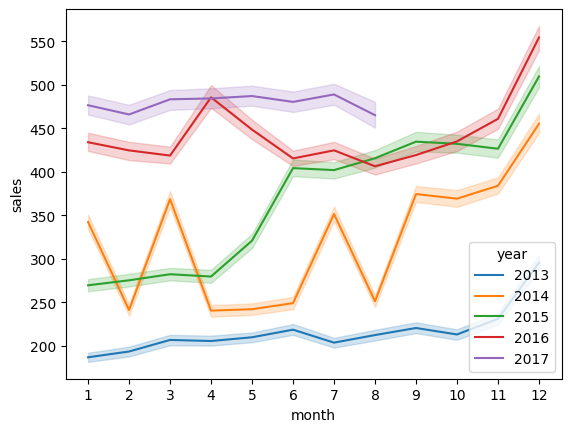

In [11]:
sns.lineplot(data = train_df, x= 'month', y = 'sales', hue = 'year')

In [13]:
data = train_df.loc[('2016-07-31' < train_df['date'] )& (train_df['date']  < '2016-09-01')]
data.head()


id       date  store_nbr      family   sales  onpromotion  \
2325510  2325510 2016-08-01          1  AUTOMOTIVE     3.0            0   
2325511  2325511 2016-08-01          1   BABY CARE     0.0            0   
2325512  2325512 2016-08-01          1      BEAUTY     3.0            0   
2325513  2325513 2016-08-01          1   BEVERAGES  2418.0           10   
2325514  2325514 2016-08-01          1       BOOKS     0.0            0   

         weekday month  year year_month  oil_price  transactions   city  \
2325510        1    08  2016    2016_08      40.05        1750.0  Quito   
2325511        1    08  2016    2016_08      40.05        1750.0  Quito   
2325512        1    08  2016    2016_08      40.05        1750.0  Quito   
2325513        1    08  2016    2016_08      40.05        1750.0  Quito   
2325514        1    08  2016    2016_08      40.05        1750.0  Quito   

             state type  cluster  
2325510  Pichincha    D       13  
2325511  Pichincha    D       13  
2325512  Pichincha    D       13  
2325513  Pichincha    D       13  
2325514  Pichincha    D       13

In [14]:
holidays_target_2016  = holiday_df[('2016-07-31' < holiday_df['date'] ) &( holiday_df['date'] < '2016-09-01')   ]
holidays_target_2017 = holiday_df[('2017-07-31' < holiday_df['date'] ) &( holiday_df['date'] < '2017-09-01')   ]
print(holidays_target_2016, '\n',holidays_target_2017)

          date      type    locale locale_name  \
267 2016-08-05   Holiday     Local  Esmeraldas   
268 2016-08-10   Holiday  National     Ecuador   
269 2016-08-12  Transfer  National     Ecuador   
270 2016-08-15   Holiday     Local    Riobamba   
271 2016-08-24   Holiday     Local      Ambato   

                                description  transferred  
267                 Fundacion de Esmeraldas        False  
268           Primer Grito de Independencia         True  
269  Traslado Primer Grito de Independencia        False  
270                   Fundacion de Riobamba        False  
271                     Fundacion de Ambato        False   
           date      type    locale locale_name  \
323 2017-08-05   Holiday     Local  Esmeraldas   
324 2017-08-10   Holiday  National     Ecuador   
325 2017-08-11  Transfer  National     Ecuador   
326 2017-08-15   Holiday     Local    Riobamba   
327 2017-08-24   Holiday     Local      Ambato   

                                descriptio

In [16]:
store_df[store_df['city'] == 'Ambato']

store_nbr    city       state type  cluster
22         23  Ambato  Tungurahua    D        9
49         50  Ambato  Tungurahua    A       14

In [14]:
store_df.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

          date      type    locale locale_name  \
14  2012-08-10   Holiday  National     Ecuador   
67  2013-08-10   Holiday  National     Ecuador   
130 2014-08-10   Holiday  National     Ecuador   
185 2015-08-10   Holiday  National     Ecuador   
269 2016-08-12  Transfer  National     Ecuador   
325 2017-08-11  Transfer  National     Ecuador   

                                description  transferred  
14            Primer Grito de Independencia        False  
67            Primer Grito de Independencia        False  
130           Primer Grito de Independencia        False  
185           Primer Grito de Independencia        False  
269  Traslado Primer Grito de Independencia        False  
325  Traslado Primer Grito de Independencia        False   
In 2013 and 2014 the national holidays are on weekends (Sat, Sun), In 2015-16-17 they are on working days (Mon, Fri, Fri)


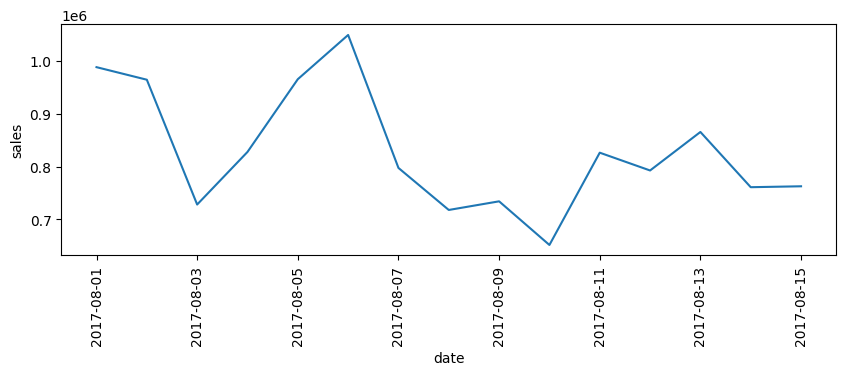

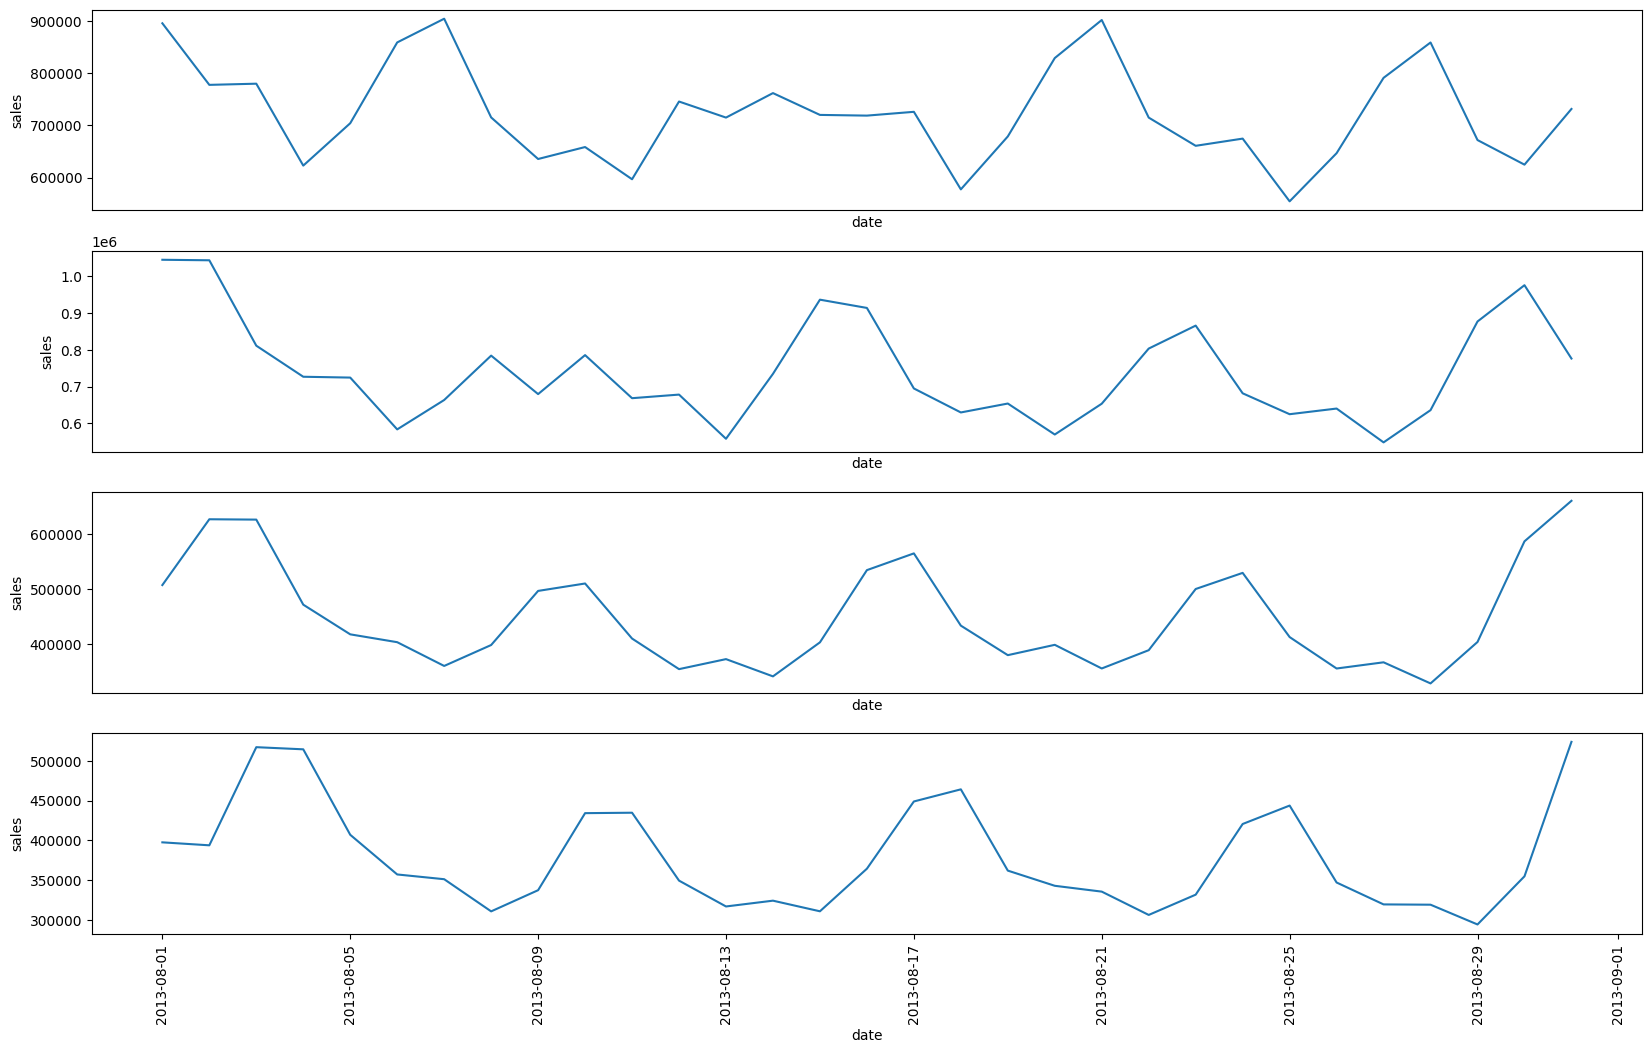

In [16]:
# Overall Sales in August in different years

national_august = national[national['date'].dt.month == 8 ]
print(national_august, '\nIn 2013 and 2014 the national holidays are on weekends (Sat, Sun), In 2015-16-17 they are on working days (Mon, Fri, Fri)')

plt.figure(figsize=(10,3))
sns.lineplot(data = train_df.loc[('2017-07-31' < train_df['date'] )& (train_df['date']  < '2017-08-16')], x= 'date', y = 'sales', estimator= 'sum', errorbar= None)
plt.xticks(rotation = 90)
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,12))
sns.lineplot(data = train_df.loc[('2016-07-31' < train_df['date'] )& (train_df['date']  < '2016-09-01')], x= 'date', y = 'sales', estimator= 'sum', errorbar= None, ax = ax1)
sns.lineplot(data = train_df.loc[('2015-07-31' < train_df['date'] )& (train_df['date']  < '2015-09-01')], x= 'date', y = 'sales', estimator= 'sum', errorbar= None, ax = ax2)
sns.lineplot(data = train_df.loc[('2014-07-31' < train_df['date'] )& (train_df['date']  < '2014-09-01')], x= 'date', y = 'sales', estimator= 'sum', errorbar= None, ax = ax3)
sns.lineplot(data = train_df.loc[('2013-07-31' < train_df['date'] )& (train_df['date']  < '2013-09-01')], x= 'date', y = 'sales', estimator= 'sum', errorbar= None, ax = ax4)
ax1.xaxis.set_ticks([])
ax2.xaxis.set_ticks([])
ax3.xaxis.set_ticks([])
ax4.tick_params(axis='x', rotation=90)
plt.show()

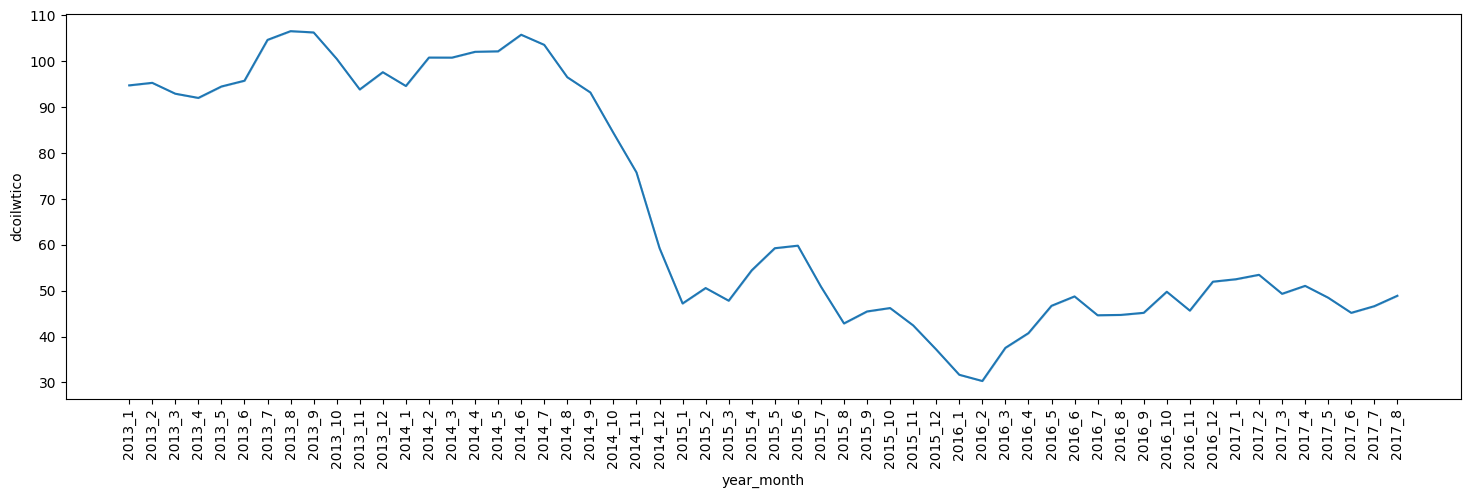

In [29]:
# OILPRICE
plt.figure(figsize=(18,5))
sns.lineplot(data = train_df, x= 'year_month', y = 'oil_price')
plt.xticks(rotation = 90)
plt.show()

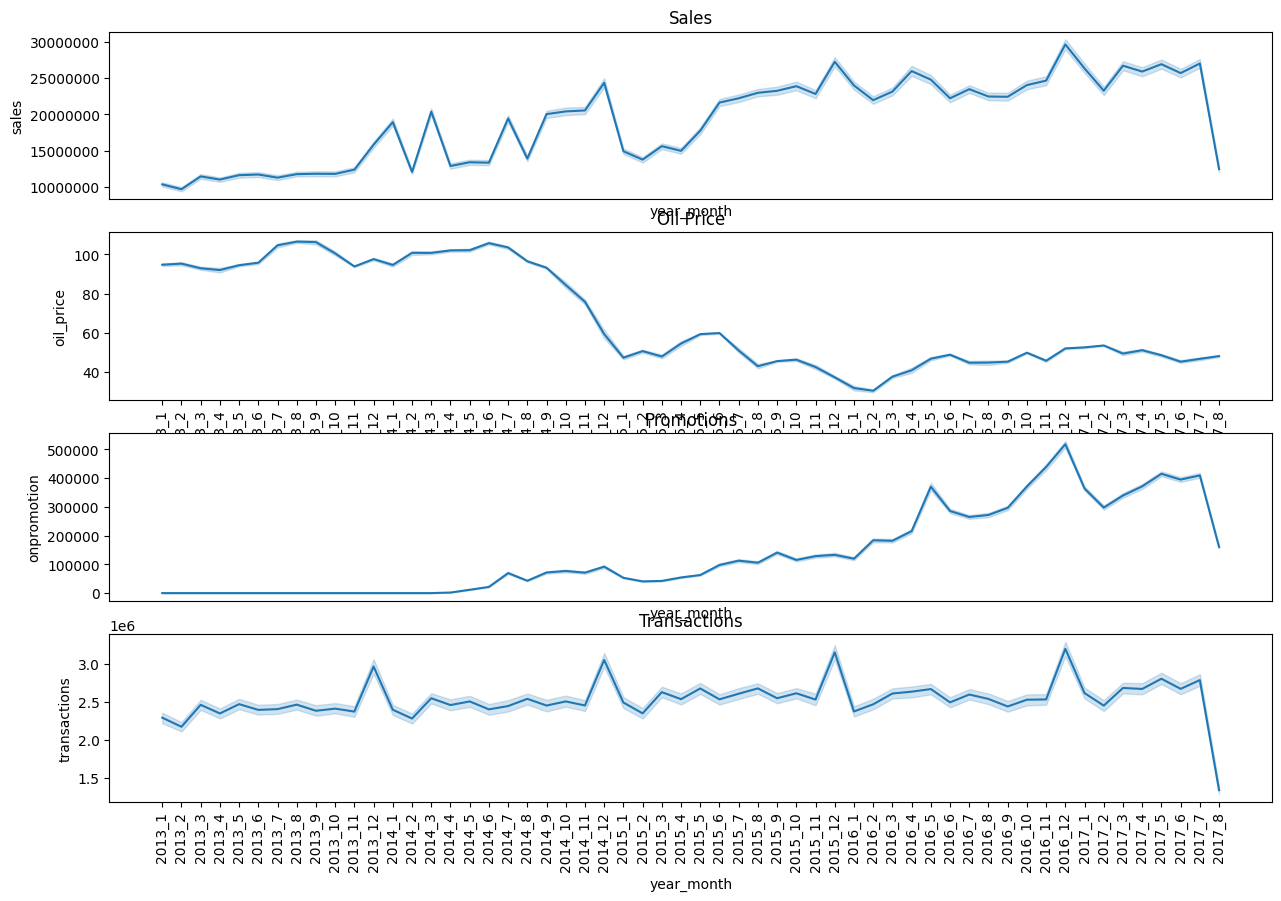

In [20]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,10))
sns.lineplot(data = train_df, x = 'year_month', y = 'sales', ax= ax1, estimator= 'sum')
sns.lineplot(data = oil_df, x = 'year_month', y = 'oil_price', ax= ax2, )
sns.lineplot(data = train_df, x = 'year_month', y = 'onpromotion', ax= ax3, estimator = 'sum' )
sns.lineplot(data = transactions_df, x = 'year_month', y = 'transactions', ax= ax4, estimator = 'sum' )
ax1.xaxis.set_ticks([])
ax2.tick_params(axis='x', rotation=90)
ax3.xaxis.set_ticks([])
ax4.tick_params(axis='x', rotation=90)
ax1.set_title('Sales')
ax2.set_title('Oil Price')
ax3.set_title('Promotions')
ax4.set_title('Transactions')
format_y_axis_subplot(ax1)

In [125]:
train_df.head()

id       date  store_nbr      family   sales  onpromotion month  \
24948  24948 2013-01-15          1  AUTOMOTIVE     1.0            0    01   
24949  24949 2013-01-15          1   BABY CARE     0.0            0    01   
24950  24950 2013-01-15          1      BEAUTY     0.0            0    01   
24951  24951 2013-01-15          1   BEVERAGES  1149.0            0    01   
24952  24952 2013-01-15          1       BOOKS     0.0            0    01   

       year year_month  oil_price  ...    lag1    lag7 lag14 weekday_1  \
24948  2013    2013_01      93.26  ...     2.0     2.0   0.0     False   
24949  2013    2013_01      93.26  ...     0.0     0.0   0.0     False   
24950  2013    2013_01      93.26  ...     2.0     3.0   0.0     False   
24951  2013    2013_01      93.26  ...  1178.0  1029.0   0.0     False   
24952  2013    2013_01      93.26  ...     0.0     0.0   0.0     False   

       weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  weekday_7  
24948       True      False      False      False      False      False  
24949       True      False      False      False      False      False  
24950       True      False      False      False      False      False  
24951       True      False      False      False      False      False  
24952       True      False      False      False      False      False  

[5 rows x 27 columns]

In [107]:
sales_by_family = train_df.groupby(by = 'family')[['sales']].sum().sort_values('sales', ascending = False)

sales_by_family_month = train_df.groupby(by =['family', 'year_month'])['sales'].sum()
sales_by_family_month = sales_by_family_month.reset_index().sort_values(['family', 'year_month'])
sales_by_family_day = train_df.groupby(by =['family', 'date'])[['sales','onpromotion']].sum().reset_index()

sales_by_store_type_month = train_df.groupby(by = ['type', 'year_month'])[['sales']].sum().reset_index()
sales_by_cluster_month = train_df.groupby(by = ['cluster', 'year_month'])[['sales']].sum().reset_index()

prod_list = list(train_df.family.unique())
store_list = list(store_df.store_nbr.unique())

In [108]:
## adding features
# adding time

complete_date_range = pd.DataFrame()
complete_date_range['date'] = pd.date_range(start=train_df['date'].min(), end=test_df['date'].max(), freq='D')
complete_date_range['time'] = complete_date_range.index
sales_by_family_day = pd.merge(sales_by_family_day, complete_date_range, how = 'left', on ='date')
train_df = pd.merge(train_df, complete_date_range, how = 'left', on ='date')

sales_by_family_day['square'] = [n**2 for n in sales_by_family_day['time']]

train_df['square'] = [n**2 for n in train_df['time']]

# adding lag
def lag_by_group(lag, database = sales_by_family_day, group = 'family'):
    final_series = pd.Series()
    for f in database[ group ].unique():
        filtered = database.loc[database[ group ] == f]
        lagged_series = filtered[ 'sales' ].shift(lag)  
        final_series = pd.concat([final_series, lagged_series])
    database[f'lag{lag}'] = final_series

lag_by_group(1)
lag_by_group(7)
lag_by_group(14)
sales_by_family_day.dropna(inplace= True)

# adding lag double-filter
def lag_by_group2(lag):
    final_series = pd.Series()
    for f in train_df[ 'family' ].unique():
        filtered = train_df.loc[train_df[ 'family' ] == f]
        for nr in train_df[ 'store_nbr' ].unique():
            filtered2 = filtered.loc[train_df[ 'store_nbr' ] == nr]
            lagged_series = filtered2[ 'sales' ].shift(lag)  
            final_series = pd.concat([final_series, lagged_series])
    train_df[f'lag{lag}'] = final_series

lag_by_group2(1)
lag_by_group2(7)
lag_by_group2(14)
lag_with_na = [n for n in train_df.columns if n.startswith('lag')]
train_df.dropna(subset= lag_with_na, inplace= True)

# adding days
def add_days(database):
    database['weekday'] = [n.isoweekday() for n in database['date']]
    database = pd.get_dummies(database, columns=['weekday'])
    return database

sales_by_family_day = add_days(sales_by_family_day)
train_df = add_days(train_df)

In [97]:
sales_by_family_day.columns
[n for n in sales_by_family_day.columns if n.startswith('lag')]

['lag1', 'lag7', 'lag14']

In [119]:
train_df

id       date  store_nbr                      family     sales  \
24948      24948 2013-01-15          1                  AUTOMOTIVE     1.000   
24949      24949 2013-01-15          1                   BABY CARE     0.000   
24950      24950 2013-01-15          1                      BEAUTY     0.000   
24951      24951 2013-01-15          1                   BEVERAGES  1149.000   
24952      24952 2013-01-15          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion month  year year_month  oil_price  ...      lag1  \
24948              0    01  2013    2013_01      93.26  ...     2.000   
24949              0    01  2013    2013_01      93.26  ...     0.000   
24950              0    01  2013    2013_01      93.26  ...     2.000   
24951              0    01  2013    2013_01      93.26  ...  1178.000   
24952              0    01  2013    2013_01      93.26  ...     0.000   
...              ...   ...   ...        ...        ...  ...       ...   
3000883            0    08  2017    2017_08      47.57  ...   283.429   
3000884            1    08  2017    2017_08      47.57  ...   114.120   
3000885          148    08  2017    2017_08      47.57  ...  1348.425   
3000886            8    08  2017    2017_08      47.57  ...   182.000   
3000887            0    08  2017    2017_08      47.57  ...    17.000   

             lag7        lag14 weekday_1  weekday_2  weekday_3  weekday_4  \
24948       2.000     0.000000     False       True      False      False   
24949       0.000     0.000000     False       True      False      False   
24950       3.000     0.000000     False       True      False      False   
24951    1029.000     0.000000     False       True      False      False   
24952       0.000     0.000000     False       True      False      False   
...           ...          ...       ...        ...        ...        ...   
3000883   358.132   570.196000     False       True      False      False   
3000884   112.954    50.462997     False       True      False      False   
3000885  2299.715  2470.461000     False       True      False      False   
3000886   170.000   203.000000     False       True      False      False   
3000887    15.678    19.316000     False       True      False      False   

         weekday_5  weekday_6  weekday_7  
24948        False      False      False  
24949        False      False      False  
24950        False      False      False  
24951        False      False      False  
24952        False      False      False  
...            ...        ...        ...  
3000883      False      False      False  
3000884      False      False      False  
3000885      False      False      False  
3000886      False      False      False  
3000887      False      False      False  

[2975940 rows x 27 columns]

In [34]:
def run_rgr(*args):
    #  preparing_data sets
    arg_list = list(args)
    y_CV_acc = np.empty((0,1))
    X_CV_acc = np.empty((0,len(args)))
    pred_CV_acc = np.empty((0,1))
    for f in sales_by_family_day[ 'family' ].unique():
        filtered = sales_by_family_day.loc[sales_by_family_day[ 'family' ] == f]
        X_train = filtered[arg_list][:-30].values
        y_train = filtered['sales'][:-30].values.reshape(-1, 1)
        X_CV = filtered[arg_list][-30:-15].values  
        y_CV = filtered['sales'][-30:-15].values.reshape(-1, 1)
        X_test = filtered[arg_list][-15:].values
        
        # scaling -  get back the same result with scaling so I am not using it
        # scaler = StandardScaler()
        # scaler.fit(X_train)
        # X_train = scaler.transform(X_train)
        # X_CV  = scaler.transform(X_CV)
        # X_test  = scaler.transform(X_test)

        rgr = linear_model.LinearRegression()
        rgr.fit(X_train, y_train)
        pred_CV = rgr.predict(X_CV)

        y_CV_acc = np.concatenate((y_CV_acc, y_CV)).reshape(-1, 1)
        pred_CV_acc = np.concatenate((pred_CV_acc, pred_CV)).reshape(-1, 1)     
        X_CV_acc = np.concatenate((X_CV_acc, X_CV))
    # not allowing negative amounts in the prediction
    pred_CV_acc[pred_CV_acc < 0] = 0

    MSLE = mean_squared_log_error(y_CV_acc, pred_CV_acc)
    print("Root Mean squared log error CV All: %.4f" % np.sqrt(MSLE))
    print("R2 CV All (r2_score method): %.4f" % r2_score(y_CV_acc, pred_CV_acc))
   



In [11]:
run_rgr('time', 'lag1', 'lag7', 'lag14','onpromotion')    



Root Mean squared log error CV All: 0.2261
R2 CV All (r2_score method): 0.9897


In [16]:
def create_plot(*args, cat ='AUTOMOTIVE'):
    #  preparing_data sets
    arg_list = list(args)
    index = prod_list.index(cat)
    y_CV_acc = np.empty((0,1))
    X_CV_acc = np.empty((0,len(args)))
    pred_CV_acc = np.empty((0,1))
    # loop through categories
    for f in sales_by_family_day[ 'family' ].unique():
        filtered = sales_by_family_day.loc[sales_by_family_day[ 'family' ] == f]
        X_train = filtered[arg_list][:-30].values
        y_train = filtered['sales'][:-30].values.reshape(-1, 1)
        X_CV = filtered[arg_list][-30:-15].values  
        y_CV = filtered['sales'][-30:-15].values.reshape(-1, 1)
        
        rgr = linear_model.LinearRegression()
        rgr.fit(X_train, y_train)
        pred_CV = rgr.predict(X_CV)
        # accumulated result of all categories
        y_CV_acc = np.concatenate((y_CV_acc, y_CV)).reshape(-1, 1)
        pred_CV_acc = np.concatenate((pred_CV_acc, pred_CV)).reshape(-1, 1)
        X_CV_acc = np.concatenate((X_CV_acc, X_CV))
    # not allowing negative amounts in the prediction
    pred_CV_acc[pred_CV_acc < 0] = 0
   
    MSLE = mean_squared_log_error(y_CV_acc[(index*15):((index+1)*15),:], pred_CV_acc[(index*15):((index+1)*15),:])
    R2 = r2_score(y_CV_acc[(index*15):((index+1)*15),:], pred_CV_acc[(index*15):((index+1)*15),:])

    fig, ax = plt.subplots()
    ax.plot(X_CV_acc[(index*15):((index+1)*15),0], y_CV_acc[(index*15):((index+1)*15),:], label = 'actual') 
    ax.plot(X_CV_acc[(index*15):((index+1)*15),0], pred_CV_acc[(index*15):((index+1)*15),:], label = 'predicted') 
    ax.set_title(f'{cat} CV_plot')
    fig.text(0.15, 0.15, "MSLE: %.4f" % MSLE) 
    fig.text(0.15, 0.20, "R2: %.4f" % R2) 
    ax.legend()
    return fig
        

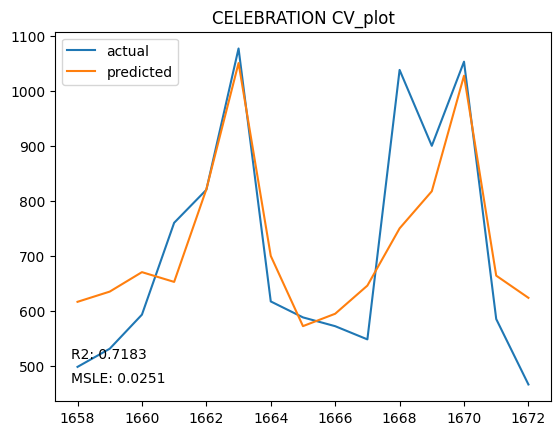

In [194]:
fig = create_plot('time', 'lag7', 'lag14', 'square', cat = 'CELEBRATION')
plt.show()
   

In [192]:
print(prod_list)

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']


In [16]:
montly_avg_sales_by_type = sales_by_store_type_month.groupby(by = 'type')[['sales']].agg(['mean', 'sum', 'nunique'])
montly_avg_sales_by_type

sales                      
              mean           sum nunique
type                                    
A     6.304354e+06  3.530438e+08      56
B     2.593940e+06  1.452606e+08      56
C     2.936335e+06  1.644347e+08      56
D     6.269345e+06  3.510833e+08      56
E     1.068258e+06  5.982244e+07      56

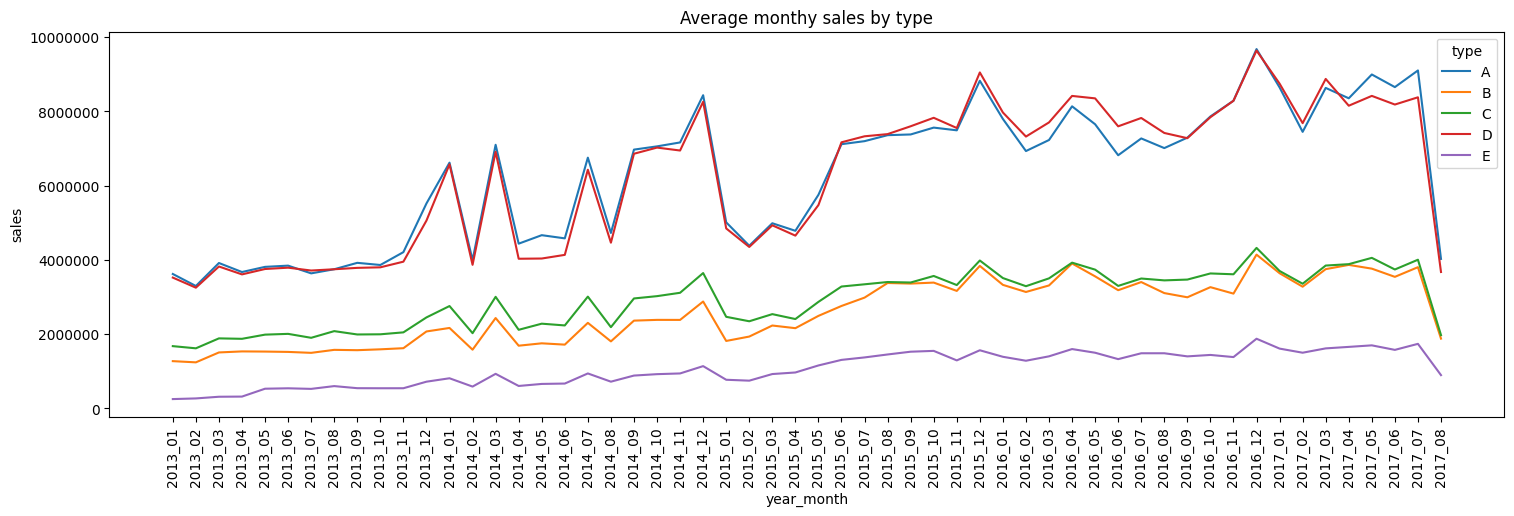

In [18]:
plt.figure(figsize=(18,5))
sns.lineplot(data = sales_by_store_type_month, x= 'year_month', y = 'sales', hue = 'type')
plt.xticks(rotation = 90)
plt.title('Average monthy sales by type')
format_y_axis()
plt.show()

In [20]:
train_df.cluster.nunique()

17

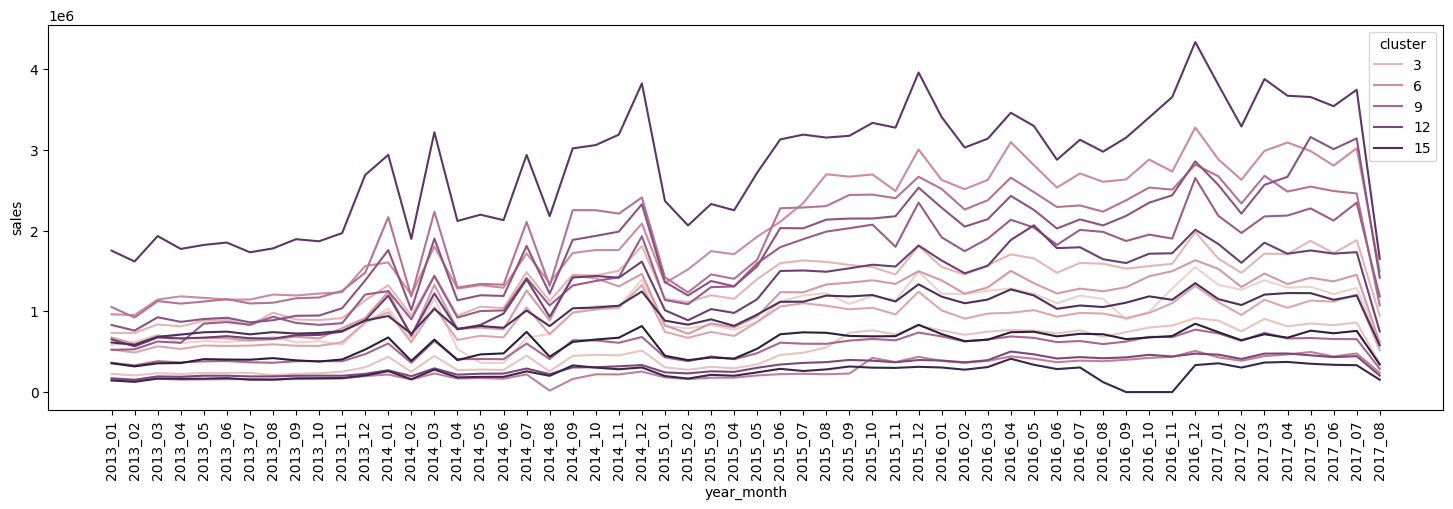

In [15]:
plt.figure(figsize=(18,5))
sns.lineplot(data = sales_by_cluster_month, x= 'year_month', y = 'sales', hue = 'cluster')
plt.xticks(rotation = 90)
plt.show()

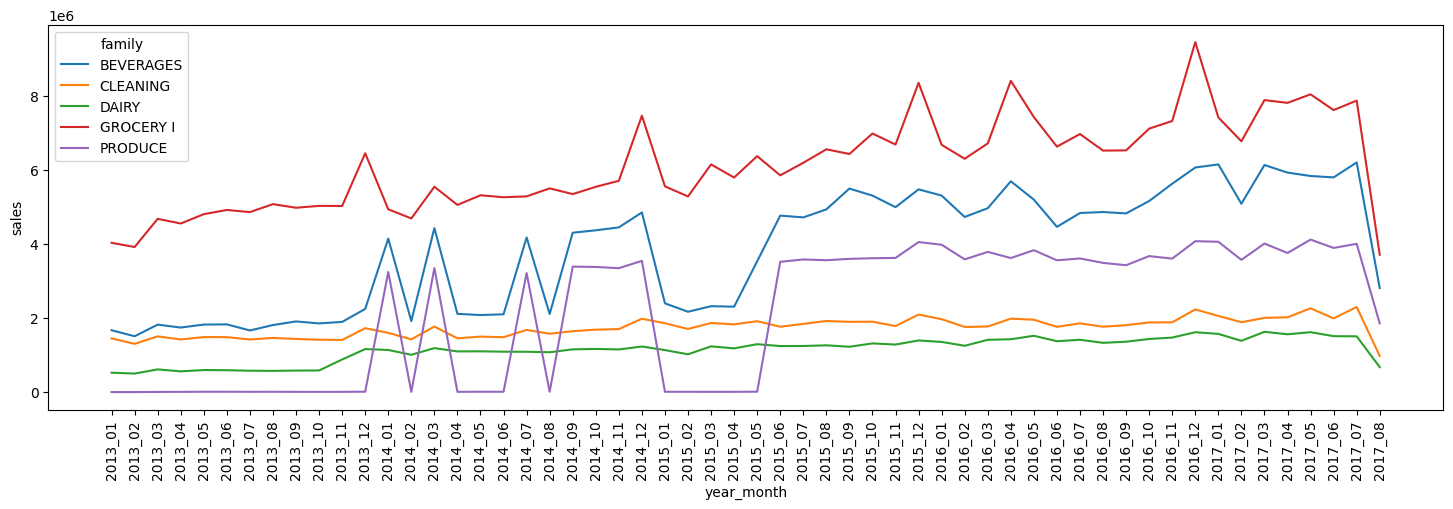

In [12]:

data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[0:5])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

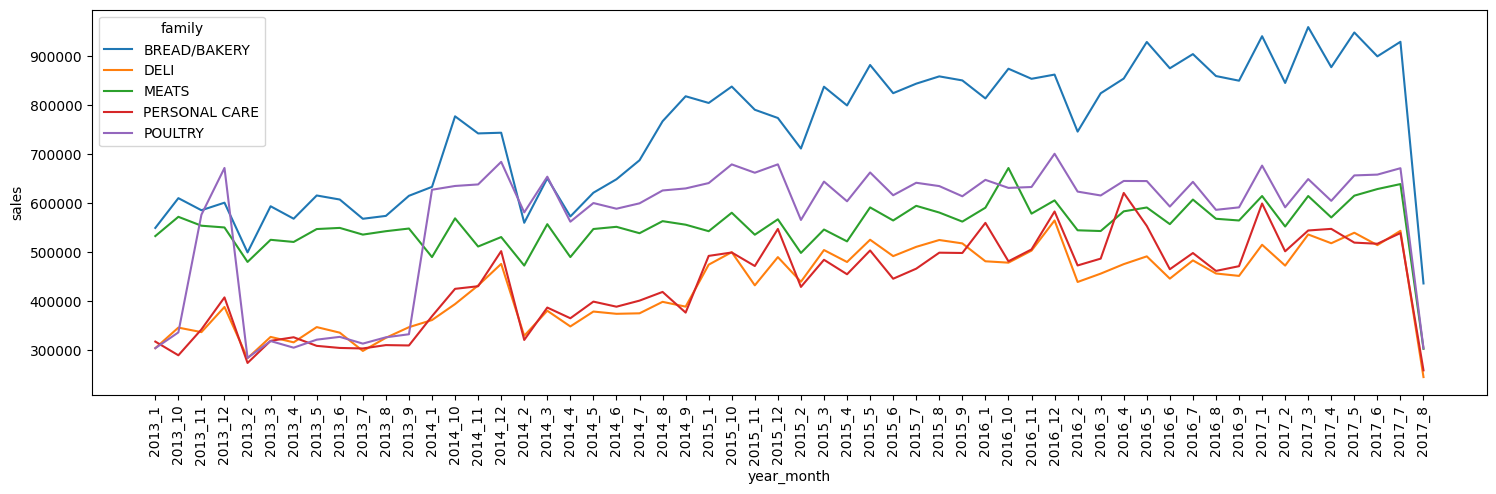

In [56]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[5:10])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

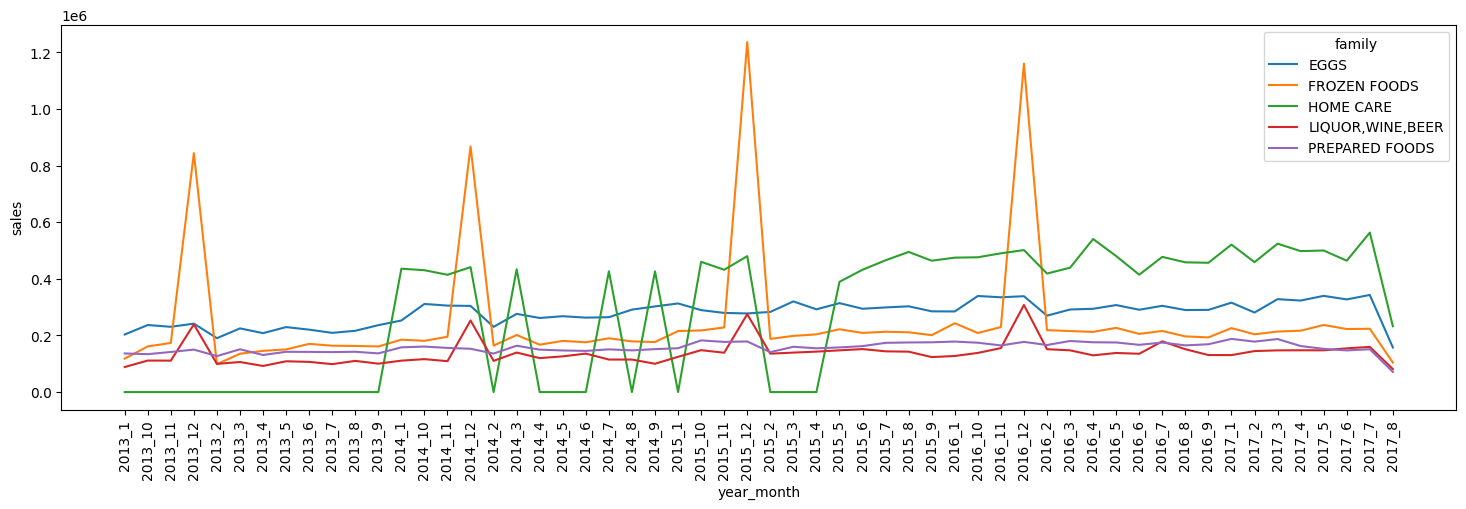

In [57]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[10:15])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

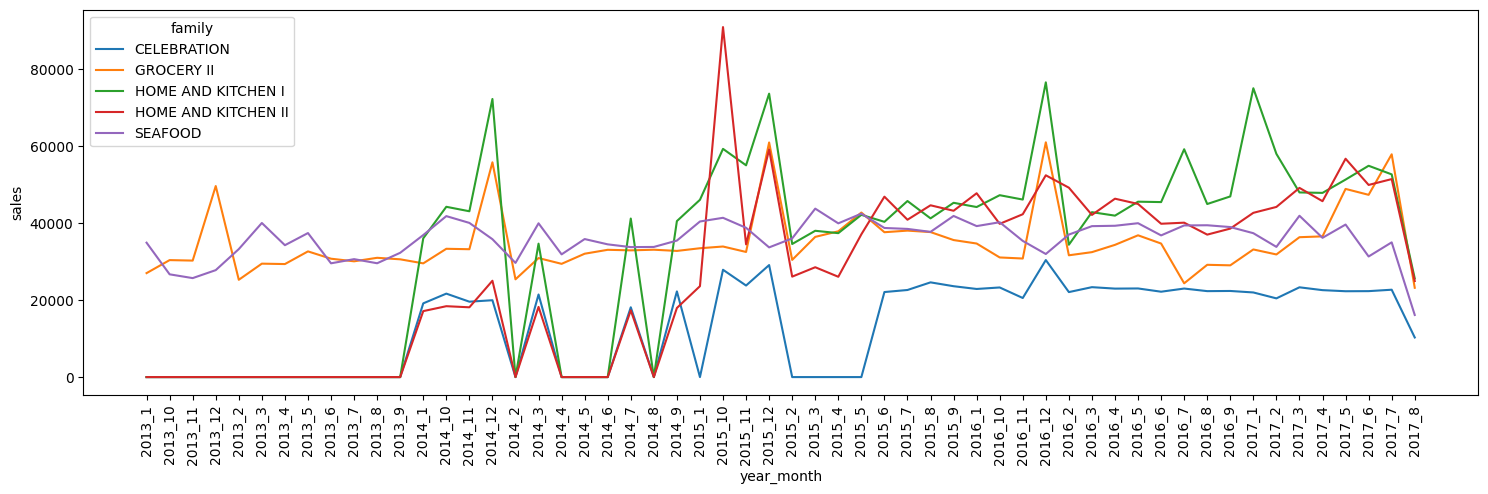

In [58]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[15:20])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

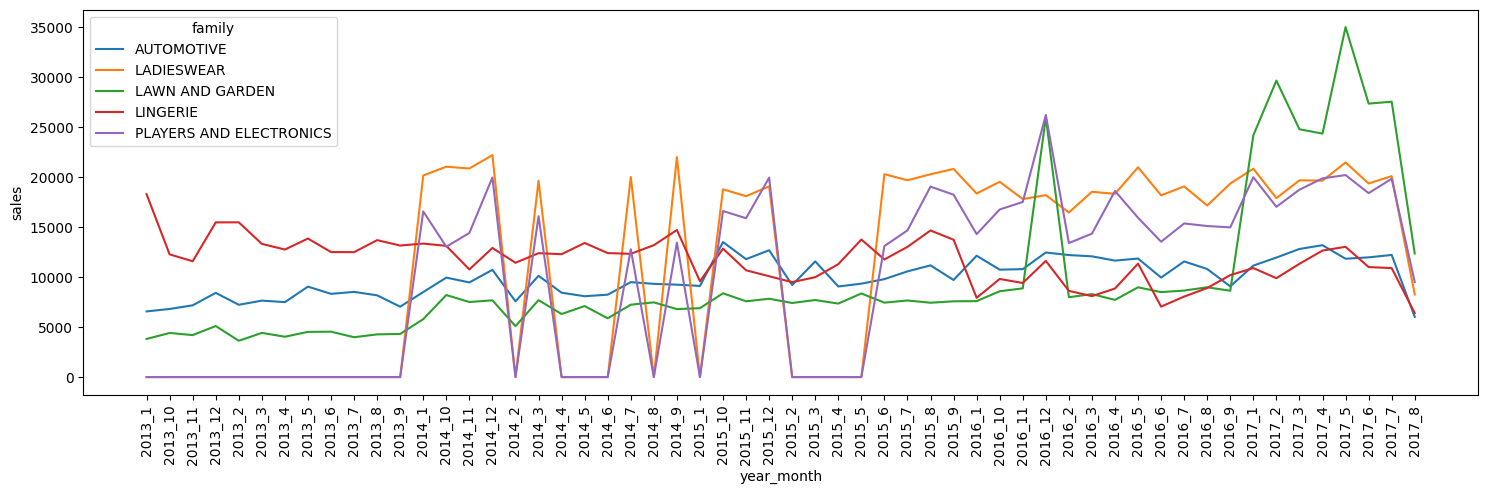

In [59]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[20:25])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

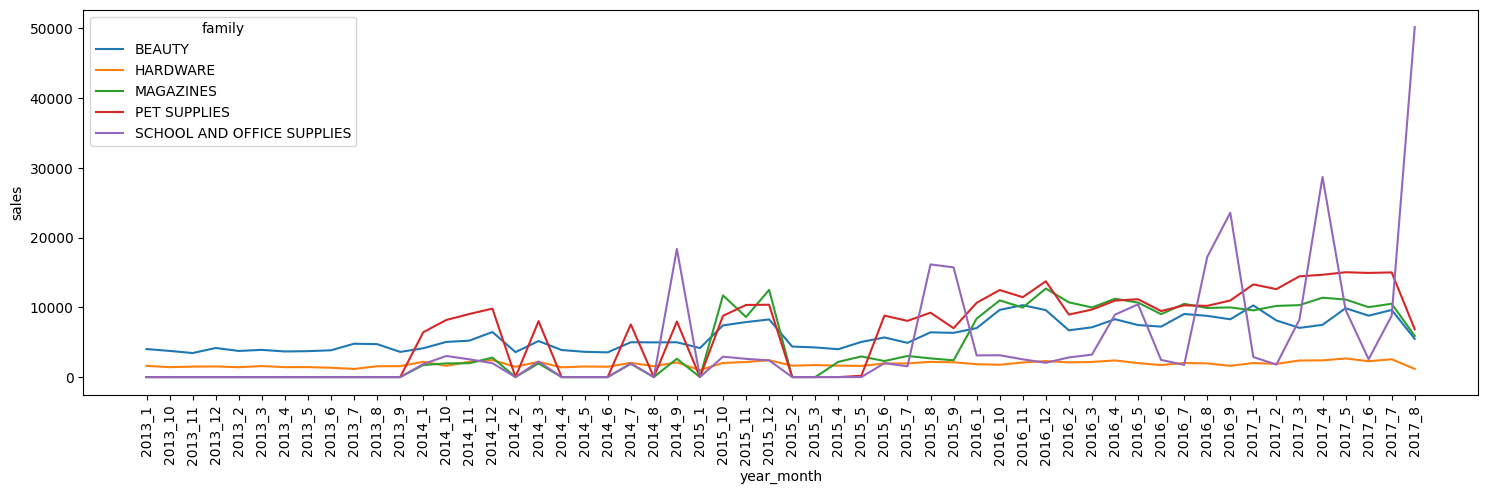

In [61]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[25:30])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

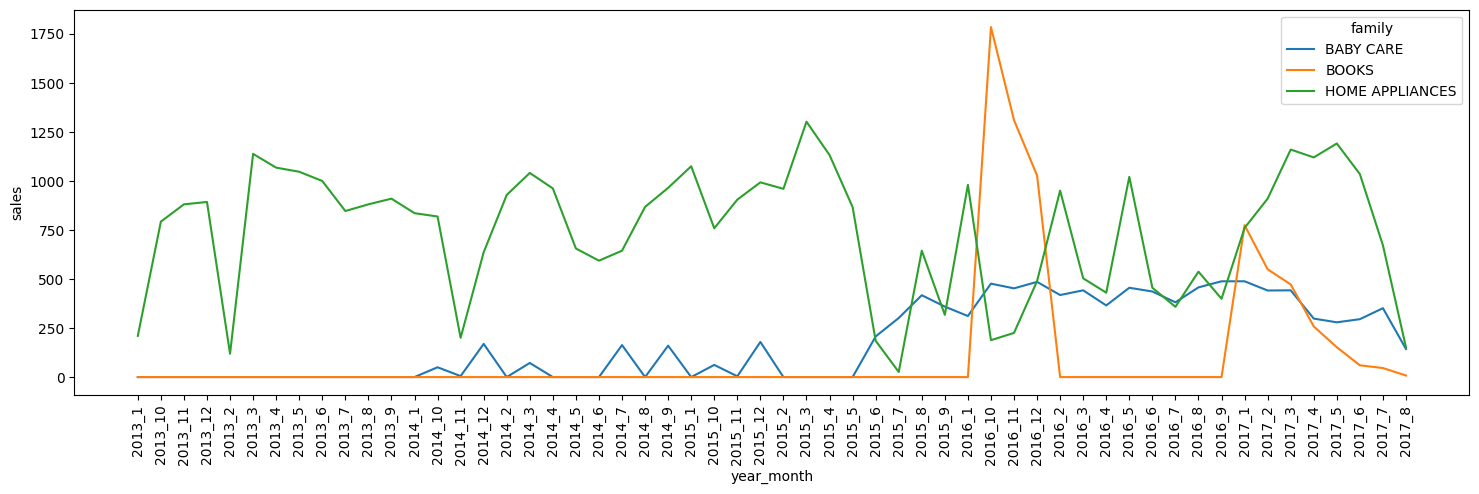

In [65]:
data = sales_by_family_month[sales_by_family_month.family.isin(sales_by_family.index[30:35])]
plt.figure(figsize=(18,5))
sns.lineplot(data = data, x= 'year_month', y = 'sales', hue = 'family')
plt.xticks(rotation = 90)
plt.show()

C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_16256\495698675.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_16256\2528175344.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


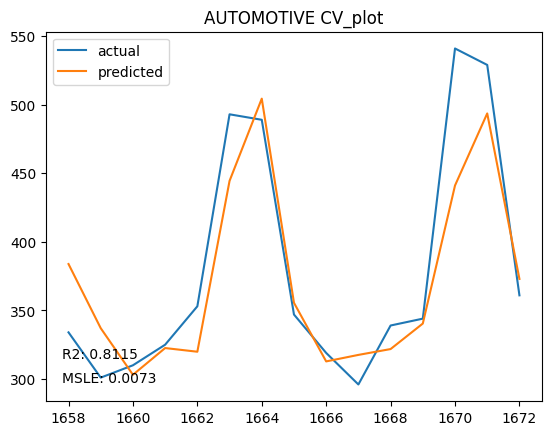

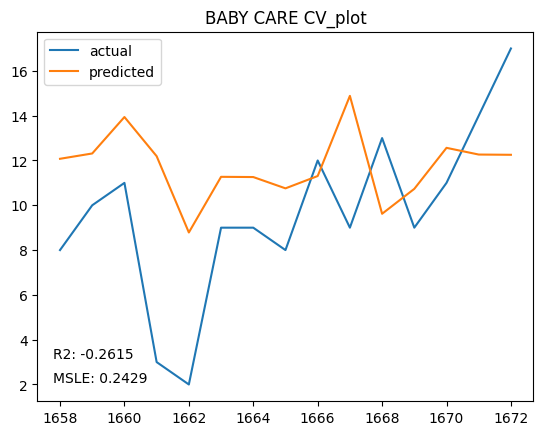

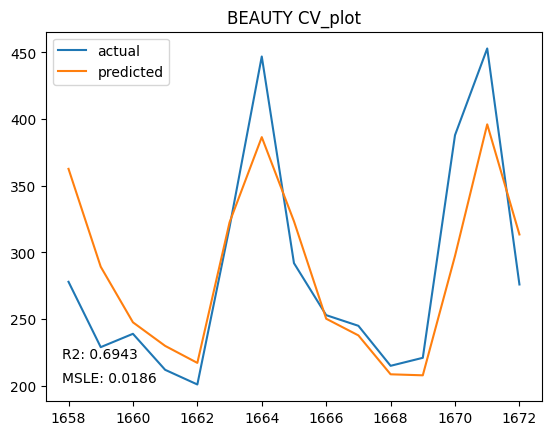

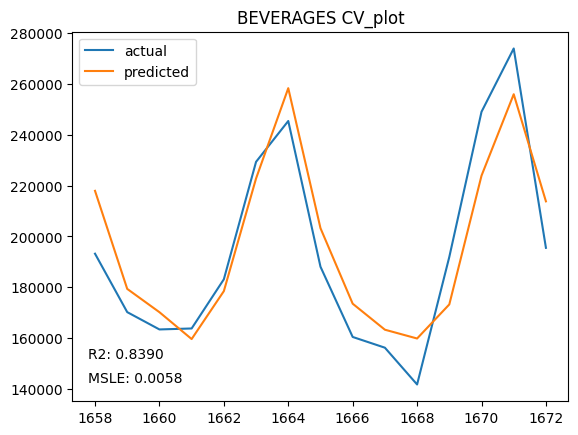

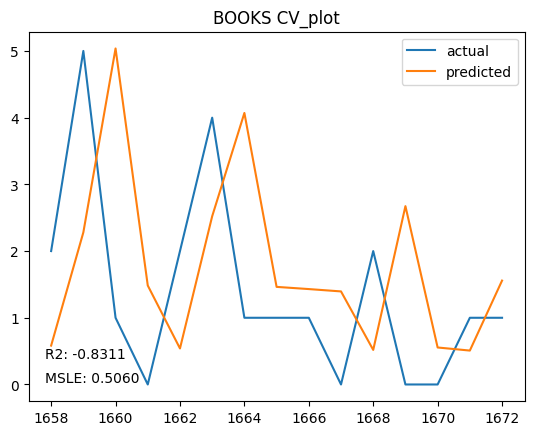

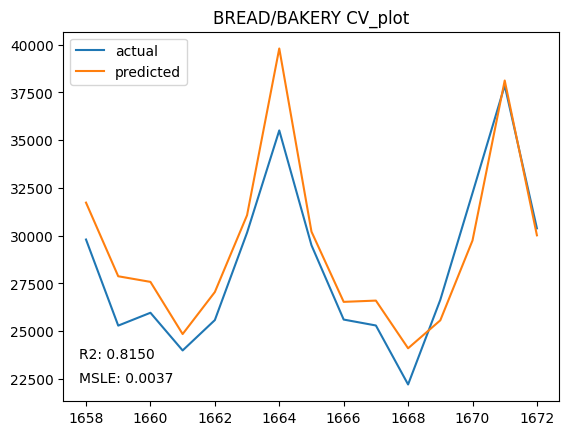

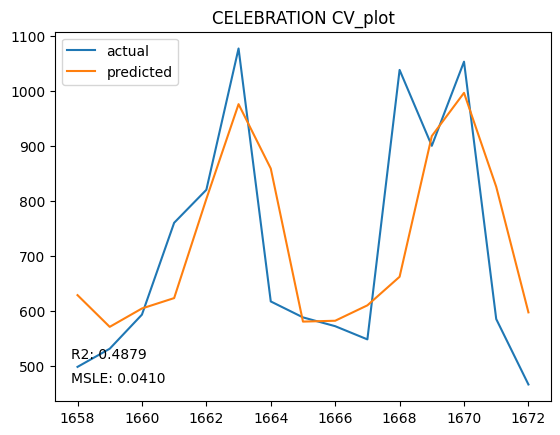

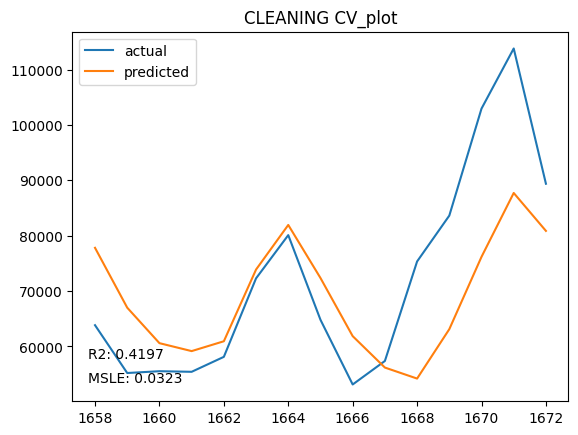

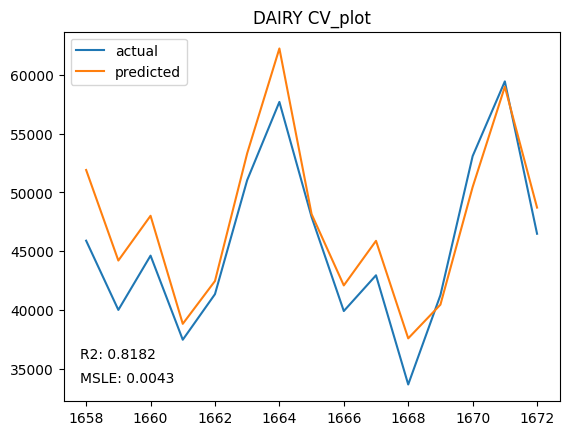

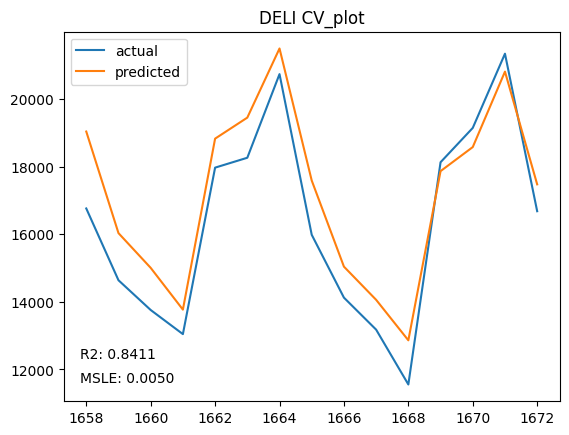

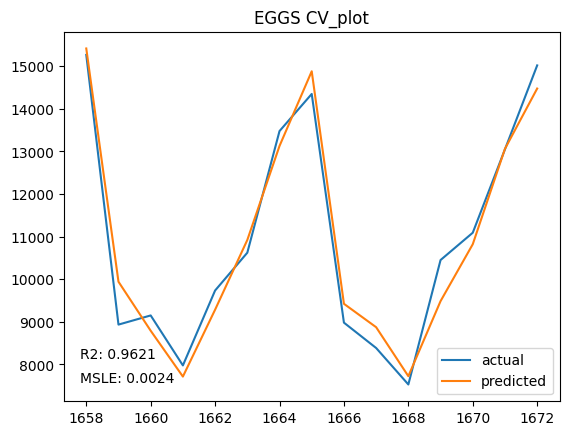

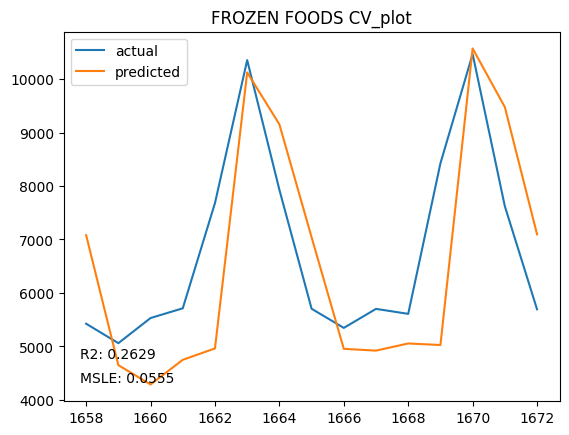

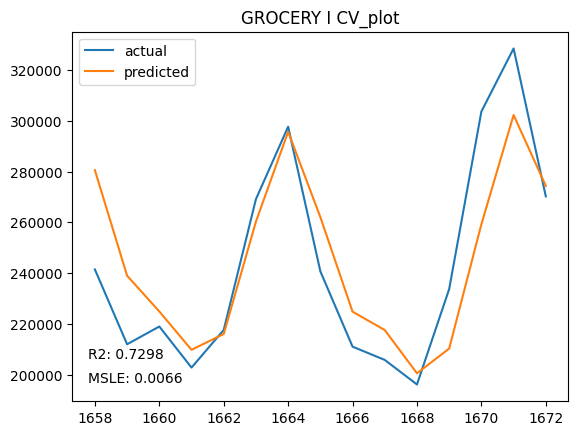

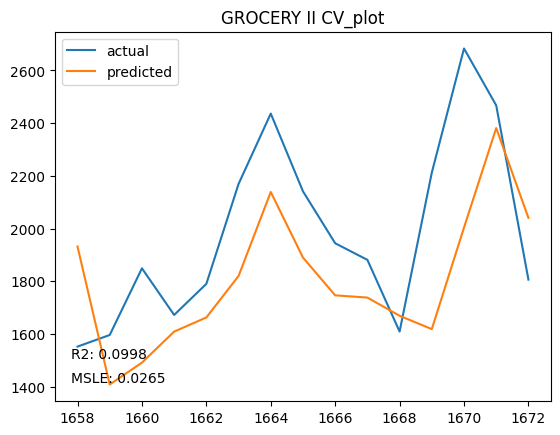

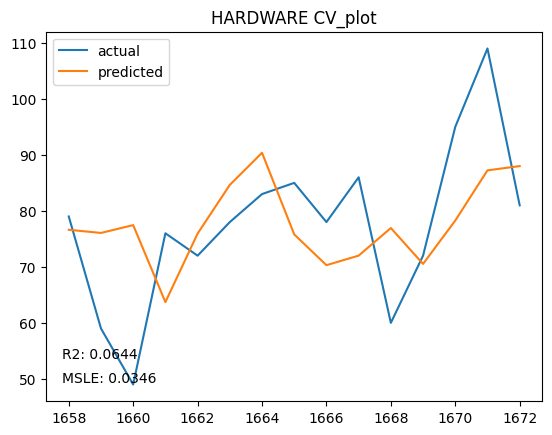

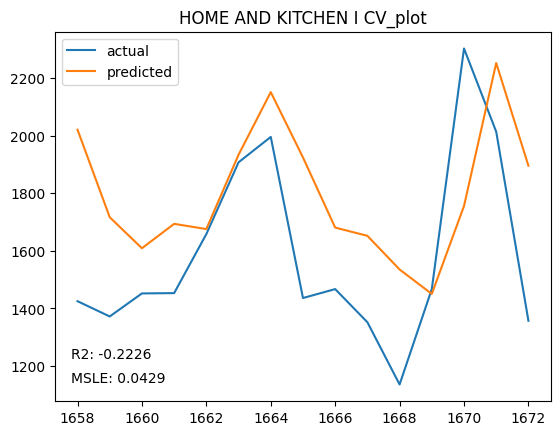

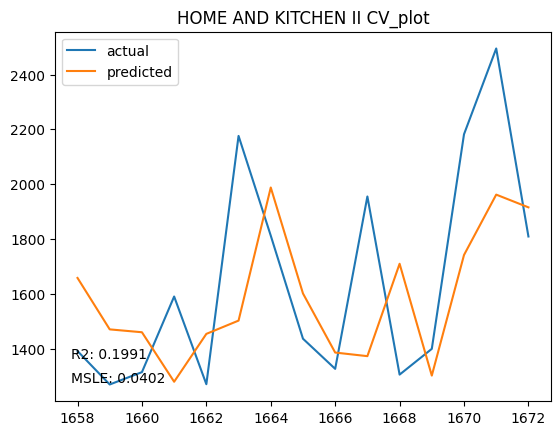

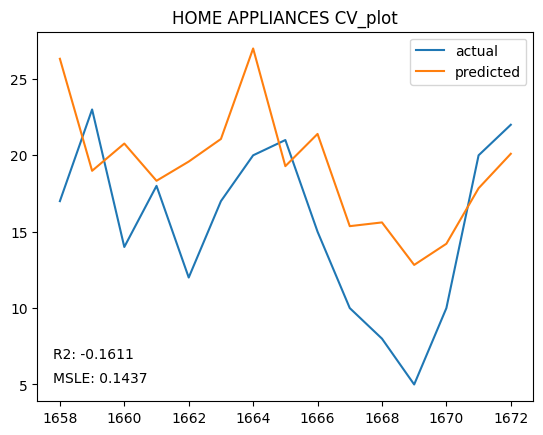

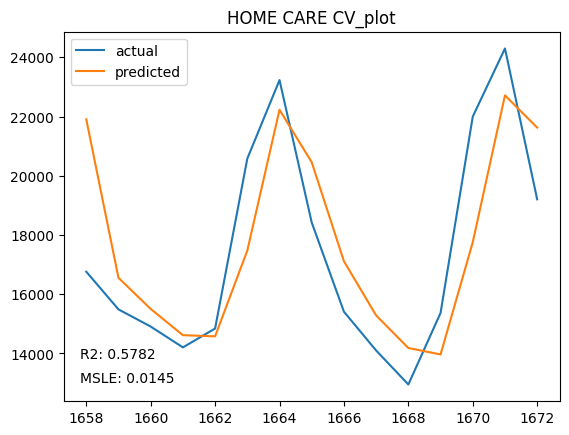

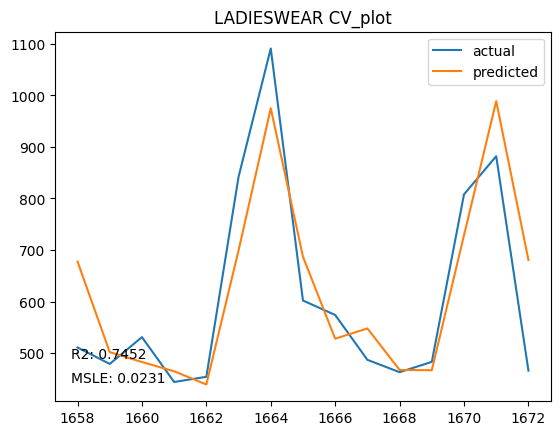

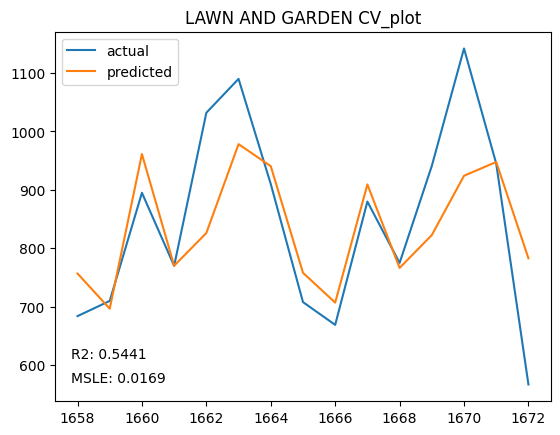

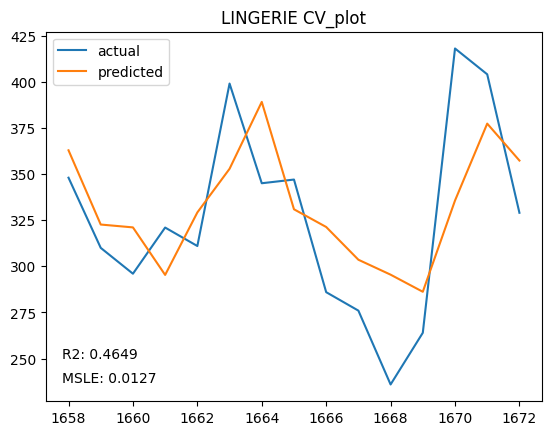

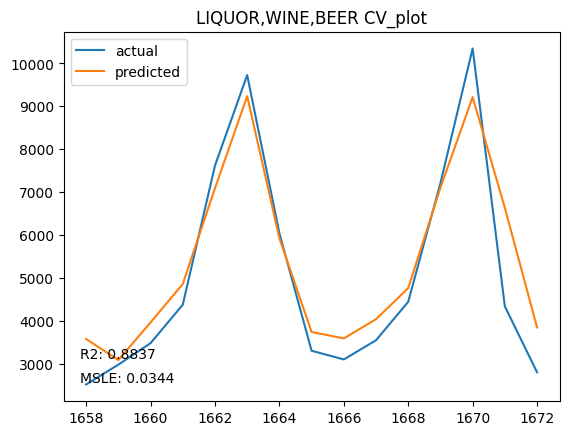

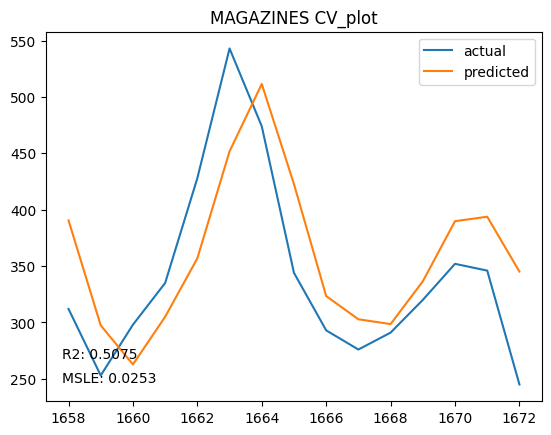

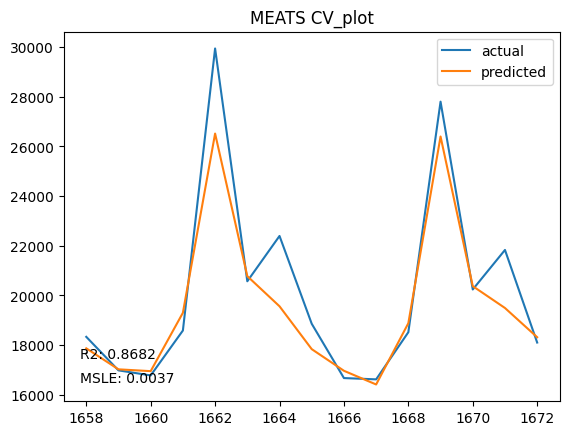

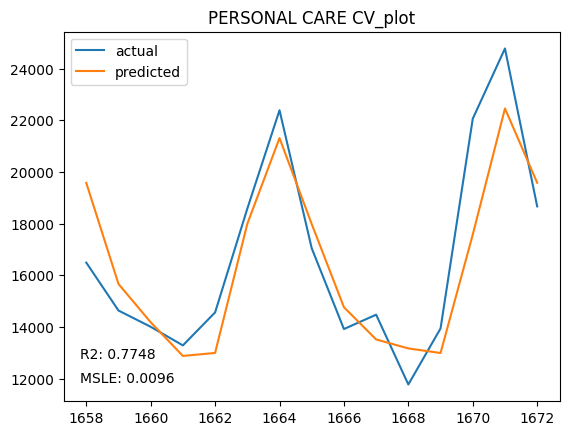

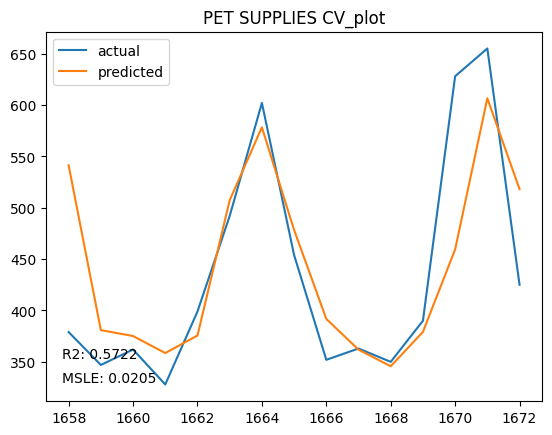

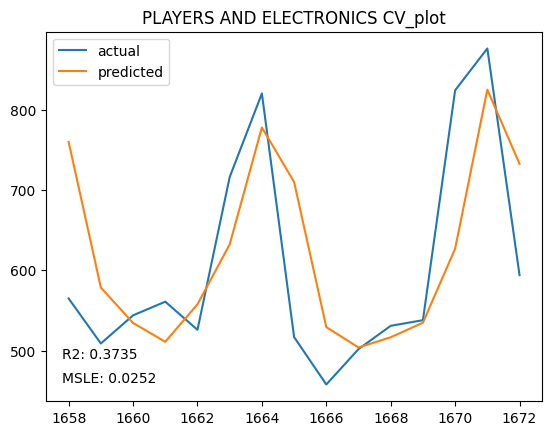

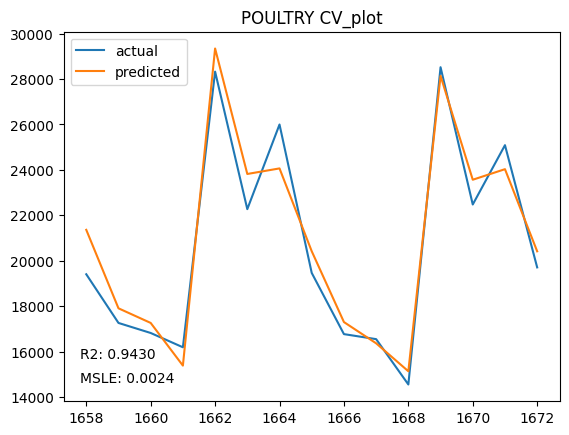

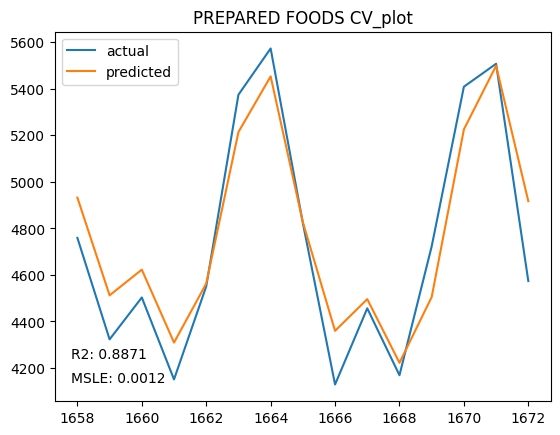

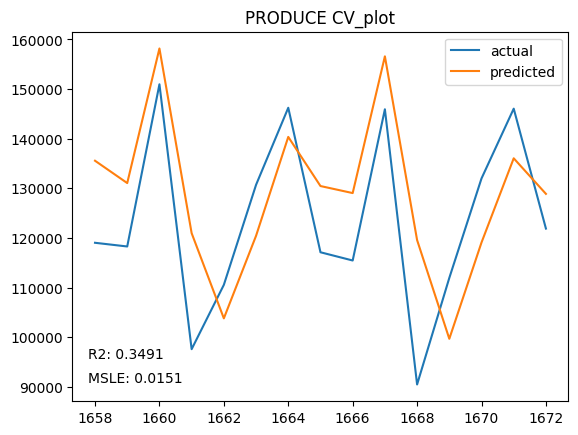

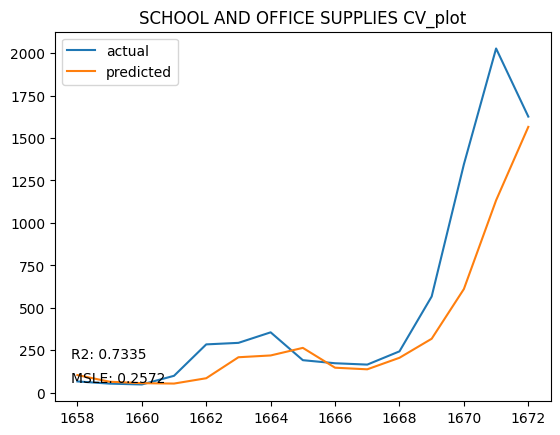

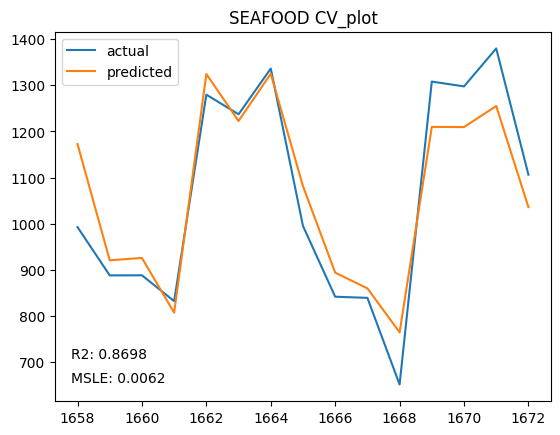

In [17]:
figures = {}
for p in prod_list:
    fig = create_plot('time', 'lag7', 'lag14', 'lag1', 'onpromotion', cat = p)
    figures[f'fig{p}'] = fig
for key, fig in figures.items():
    fig.show()